# Analyses of the paper

This notebook is doing the figures and the statistics for the paper. To use this notebook you need forst to create the jsons using `data_protnaff.ipynb`.

This notebook is quite big, you will need to run every cell in order to obtain all figures from the paper, it can take 1 hour.

First testing if the installation is correct.

In [1]:
%%bash 

if [[ -z "$PROTNAFF" ]]; then
    echo "You did not do the installation correctly, please refer to the INSTALLATION.md"
else
    if [[ -f "$PATH/x3dna-dssr" ]]; then
        echo "x3dna-dssr is not correctly installed."
    else
        echo "The installation seems correct."
    fi
fi

The installation seems correct.


Then the importation of all python packages needed to run this notebook, but also a test to know if you run the `create_json.ipynb`.

In [2]:
import os
import json
import numpy as np

#The packages for statistics
import scipy.stats
from statsmodels.stats.proportion import proportions_ztest

#The graphics libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

folder = "./data_paper"

if not os.path.isfile("{}/structures.json".format(folder)) or not os.path.isfile("{}/fragments.json".format(folder)):
    print("You need to run the data_protnaff.ipynb first.")
else:
    print("You can continue.")

You can continue.


The `structures` and `fragments` dictionnaries will be used in several cells.

In [3]:
structures = json.load(open("{}/structures.json".format(folder)))
fragments = json.load(open("{}/fragments_clust.json".format(folder)))

In [4]:
fragments['AAA']['1']

{'chain': 'B',
 'clust0.2': 1,
 'clust0.2_center': True,
 'clust1.0': 1,
 'clust1.0_center': False,
 'clust3.0': 1,
 'clust3.0_center': False,
 'indices': [1, 2, 3],
 'missing_atoms': [0, 0, 0],
 'model': 1,
 'resid': ['201', '202', '203'],
 'seq': 'GGA',
 'structure': '1A1T'}

## Do NMR structures contain more ssRNA than X-ray structures?

Here are simple statistics, the `structures` is parsed, and for each structure, the experimental method is count as x-ray or nmr.

Then a percentage of each method is made and an exact fisher test is performed to know if the results are different or not.

In [5]:
result = {"x-ray":{"ss":0, "ds":0}, "nmr":{"ss":0, "ds":0}}

x = 0
n = 0

for value in structures.values():
    if value["method"] == "x-ray diffraction":
        x += 1
        for chain in value['ss'].values():
            for res in chain.values():
                if res[0] == "D":
                    result["x-ray"]["ds"] += 1
                else:
                    result["x-ray"]["ss"] += 1
    elif value["method"] == "solution nmr" or value["method"] == "solution nmr; theoretical model" or value["method"] == "solid-state nmr":
        n += 1
        for chain in value['ss'].values():
            for res in chain.values():
                if res[0] == "D":
                    result["nmr"]["ds"] += 1
                else:
                    result["nmr"]["ss"] += 1
print(result)
print("Structures from X-ray: {}, structures from NMR: {}".format(x,n))
x_per = round((result["x-ray"]['ss']*100/(result["x-ray"]['ss'] + result["x-ray"]['ds'])),2)
rmn_per = round((result["nmr"]['ss']*100/(result["nmr"]['ss']+result["nmr"]['ds'])),2)
print("Percentages ss: X-ray: {}%, NMR: {}%".format(x_per, rmn_per))

(oddsratio, pvalue) = scipy.stats.fisher_exact([[result["x-ray"]['ss'], result["nmr"]['ss']], [result["x-ray"]['ds'], result["nmr"]['ds']]])
print("The p-value of the exact fisher test is: {:.3f}".format(pvalue))

{'x-ray': {'ss': 21216, 'ds': 28008}, 'nmr': {'ss': 1175, 'ds': 1926}}
Structures from X-ray: 1124, structures from NMR: 131
Percentages ss: X-ray: 43.1%, NMR: 37.89%
The p-value of the exact fisher test is: 0.000


## Conformational diversity of RNA fragments at different scales

The first cell is making the figure showing the number of elements in the clusters at 1A and 3A.

The second cell is showing in details the composition of those clusters, by printing the number of clusters of a given size (number of elements).

The next cell is doing the Figure 2 of the paper (link).

/home/amoniot/miniconda3/envs/protnaff/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


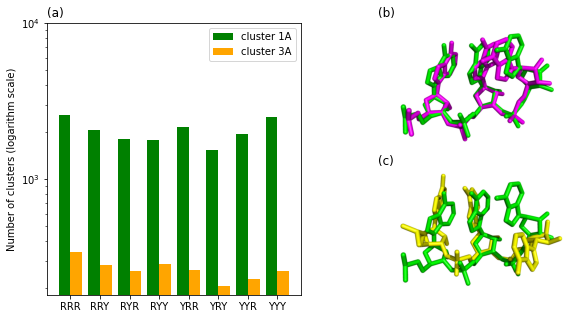

In [6]:
tick = ["RRR", "RRY", "RYR", "RYY", "YRR", "YRY", "YYR", "YYY"]
motifs = ['AAA', 'AAC', 'ACA', 'ACC', 'CAA', 'CAC', 'CCA', 'CCC']
clust_1A = []
clust_3A = []
for motif in motifs:
    with open("{}/trilib/{}-dr0.2r-clust1.0".format(folder, motif)) as ff:
        for n_line_1A, _ in enumerate(ff):
            pass
        clust_1A.append(n_line_1A)
    with open("{}/trilib/{}-dr0.2r-clust1.0-clust3.0".format(folder, motif)) as ff3:
        for n_line_3A, _ in enumerate(ff3):
            pass
        clust_3A.append(n_line_3A)

plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(2, 2)
ax = plt.subplot(gs[:, 0])
ax.set_title('(a)', loc='left')
plt.bar([1, 2, 3, 4, 5, 6, 7, 8], clust_1A, 0.4, label="cluster 1A", log=True, color='green')
plt.bar([1.4, 2.4, 3.4, 4.4, 5.4, 6.4, 7.4, 8.4], clust_3A, 0.4, label="cluster 3A", log=True, color='orange')
plt.ylabel("Number of clusters (logarithm scale)")
plt.xticks([1.2, 2.2, 3.2, 4.2, 5.2, 6.2, 7.2, 8.2], tick)
plt.ylim(1, 10000)
plt.legend()
ax = plt.subplot(gs[0, 1])
ax.set_title('(b)', loc='left')
img = mpimg.imread('./alignement_1A.png')
imgplot = plt.imshow(img)
plt.axis('off')
ax = plt.subplot(gs[1, 1])
ax.set_title('(c)', loc='left')
img = mpimg.imread('./alignement_3A.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.savefig('fig2.png', facecolor="w")
plt.show()

The next cell is doing the Figure 3 of the paper.

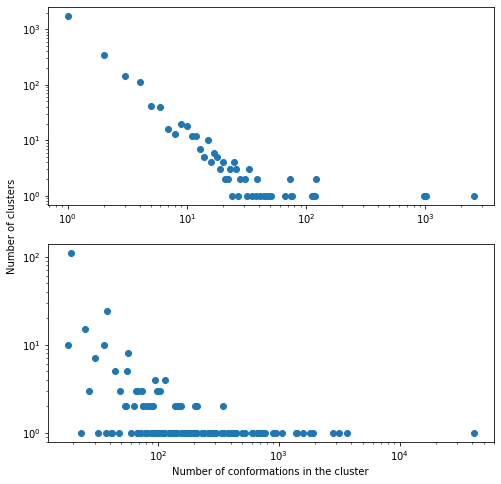

In [7]:
def create_fig3(file_cluster1A, file_cluster3A):
    with open(file_cluster1A) as ff:
        lines1A = ff.readlines()
    res1A = {}
    for line in lines1A:
        line = line.split(' ')
        len_line = len(line) - 4
        if len_line in res1A.keys():
            res1A[len_line] += 1
        else:
            res1A[len_line] = 1
    with open(file_cluster3A) as ff:
        lines3A = ff.readlines()
    res3A = {}
    for line in lines3A:
        line = line.split(' ')
        len_line3A = 0
        for cc in line[4:-1]:
            len_line3A += len(lines1A[int(cc)-1]) -4
        if len_line3A in res3A.keys():
            res3A[len_line3A] += 1
        else:
            res3A[len_line3A] = 1
    return res1A, res3A

res_1A, res_3A = create_fig3("{}/trilib/AAA-dr0.2r-clust1.0".format(folder), \
                             "{}/trilib/AAA-dr0.2r-clust1.0-clust3.0".format(folder))
        
# Then creation of plots
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(2, 1)
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(res_1A.keys(), res_1A.values())
ax1.set_xscale("log")
ax1.set_yscale("log")
ax2 = plt.subplot(gs[1, 0])
ax2.scatter(res_3A.keys(), res_3A.values())
ax2.set_xscale("log")
ax2.set_yscale("log")

fig.text(0.055, 0.5, "Number of clusters", va='center', rotation='vertical')
plt.xlabel("Number of conformations in the cluster")
plt.savefig("fig3.png", facecolor="w", bbox_inches='tight')
plt.show()

## RNA local conformations induced by protein binding

In this part of the paper, we are interested in the conformations that are induced by the contact with the protein. To understand if the contact with the protein is implying particular conformations, we are parsing the `fragments` dictionnary and extracting the informations about all clusters. The clusters can be fully single-strande, or fully double stranded or a mix of ss and ds conformations. They also can be fully in contact or fully not in contact or a mix betwwen contact and no contact with the protein.

In [8]:
def parsing_fragments(fragments, structures, cutoff):
    """
    This function will parse the fragments dictionnary to extract information about clusters, 
    then it will parse those clusters to extract their properties.
    results are the results for each clusters
    res_bis is a sum of information by clusters
    """
    results = {"AAA":{}, "AAC":{}, "ACA":{}, "ACC":{}, "CAA":{}, "CAC":{}, "CCA":{}, "CCC":{}}
    res_bis = {"AAA":{}, "AAC":{}, "ACA":{}, "ACC":{}, "CAA":{}, "CAC":{}, "CCA":{}, "CCC":{}}
    for key in results.keys():
        for key2 in fragments[key].keys():
            model = "model_" + str(fragments[key][key2]["model"])
            chain = "chain_" + str(fragments[key][key2]["chain"])
            contact = False
            interface = set()
            for nucl in structures[fragments[key][key2]['structure']]["interface_protein"]["model_1"][chain].keys():
                interface.add(nucl.split('_')[1])
            ss=True
            ds=0
            for nucl in fragments[key][key2]['indices']:
                if str(nucl) in interface:
                    contact = True
                if structures[fragments[key][key2]['structure']]["ss"][chain]["res_"+str(nucl)][0]=="D":
                    ss=False
                    ds+=1
            if fragments[key][key2][cutoff] not in results[key].keys():
                results[key][fragments[key][key2][cutoff]] = {"contact_ss":0, "contact_ds":0, "contact_mixte":0, "nocontact_ss":0, "nocontact_ds":0, "nocontact_mixte":0}
            if contact:
                if ss:
                    results[key][fragments[key][key2][cutoff]]["contact_ss"] += 1
                elif ds == 3:
                    results[key][fragments[key][key2][cutoff]]["contact_ds"] += 1
                else:
                    results[key][fragments[key][key2][cutoff]]["contact_mixte"] += 1
            else:
                if ss:
                    results[key][fragments[key][key2][cutoff]]["nocontact_ss"] += 1
                elif ds == 3:
                    results[key][fragments[key][key2][cutoff]]["nocontact_ds"] += 1
                else:
                    results[key][fragments[key][key2][cutoff]]["nocontact_mixte"] += 1
        con_ss = 0
        sum_con_ss = 0
        con_ds = 0
        sum_con_ds = 0
        con_mixte = 0
        sum_con_mixte = 0
        nocon_ss = 0
        sum_nocon_ss = 0
        nocon_ds = 0
        sum_nocon_ds = 0
        nocon_mixte = 0
        sum_nocon_mixte = 0
        mixte_ss = 0
        sum_mixte_ss = 0
        mixte_ds = 0
        sum_mixte_ds = 0
        mixte_mixte = 0
        sum_mixte_mixte=0
        for clust in results[key].keys():
            #if there is at least 3 fragments in the cluster:
            if results[key][clust]["contact_ss"] + results[key][clust]["contact_ds"] + results[key][clust]["contact_mixte"] + results[key][clust]["nocontact_ss"] + results[key][clust]["nocontact_ds"] + results[key][clust]["nocontact_mixte"] > 2:
                if results[key][clust]["nocontact_mixte"] == 0 and results[key][clust]["nocontact_ds"] == 0 and results[key][clust]["nocontact_ss"] == 0:
                    if results[key][clust]["contact_mixte"] > 0:
                        con_mixte += 1
                        sum_con_mixte += results[key][clust]["contact_ss"] + results[key][clust]["contact_ds"] + results[key][clust]["contact_mixte"]
                    else:
                        if results[key][clust]["contact_ds"] == 0:
                            con_ss += 1
                            sum_con_ss += results[key][clust]["contact_ss"]
                        else:
                            con_ds += 1
                            sum_con_ds += results[key][clust]["contact_ds"]
                elif results[key][clust]["contact_ss"] == 0 and results[key][clust]["contact_ds"] == 0 and results[key][clust]["contact_mixte"] == 0:
                    if results[key][clust]["nocontact_mixte"] > 0:
                        nocon_mixte += 1
                        sum_nocon_mixte += results[key][clust]["nocontact_ss"] + results[key][clust]["nocontact_ds"] + results[key][clust]["nocontact_mixte"]
                    else:
                        if results[key][clust]["nocontact_ss"] == 0:
                            nocon_ds += 1
                            sum_nocon_ds += results[key][clust]["nocontact_ds"]
                        else:
                            nocon_ss += 1
                            sum_nocon_ss += results[key][clust]["nocontact_ss"]
                else:
                    if results[key][clust]["nocontact_mixte"] > 0 or results[key][clust]["contact_mixte"] > 0 or (results[key][clust]["nocontact_ss"] != 0 and results[key][clust]["nocontact_ds"] !=0) or (results[key][clust]["contact_ss"] != 0 or results[key][clust]["contact_ds"] !=0):
                        mixte_mixte += 1
                        sum_mixte_mixte += results[key][clust]["nocontact_ss"] + results[key][clust]["nocontact_ds"] + results[key][clust]["nocontact_mixte"] + results[key][clust]["contact_ss"] + results[key][clust]["contact_ds"] + results[key][clust]["contact_mixte"]
                    else:
                        if results[key][clust]["contact_ss"] == 0 and results[key][clust]["nocontact_ss"] == 0:
                            mixte_ds += 1
                            sum_mixte_ds += results[key][clust]["nocontact_ds"] + results[key][clust]["contact_ds"]
                        else:
                            mixte_ss += 1
                            sum_mixte_ss += results[key][clust]["contact_ss"] + results[key][clust]["nocontact_ss"]             

        res_bis[key] = {"contact_ss":con_ss, "contact_ds":con_ds, "contact_mixte":con_mixte, "nocontact_ss":nocon_ss, "nocontact_ds":nocon_ds, "nocontact_mixte":nocon_mixte, "mixte_ss":mixte_ss, "mixte_ds":mixte_ds, "mixte_mixte":mixte_mixte, \
                       "sum_contact_ss":sum_con_ss, "sum_contact_ds":sum_con_ds, "sum_contact_mixte":sum_con_mixte, \
                       "sum_nocontact_ss":sum_nocon_ss, "sum_nocontact_ds":sum_nocon_ds, "sum_nocontact_mixte":sum_nocon_mixte,\
                       "sum_mixte_ss":sum_mixte_ss, "sum_mixte_ds":sum_mixte_ds, "sum_mixte_mixte":sum_mixte_mixte}

    return results, res_bis

In [9]:
results_1A, res_cluster_1A = parsing_fragments(fragments, structures, 'clust1.0')
results_3A, res_cluster_3A = parsing_fragments(fragments, structures, 'clust3.0')

The next cell is making Figure.4 of the paper.

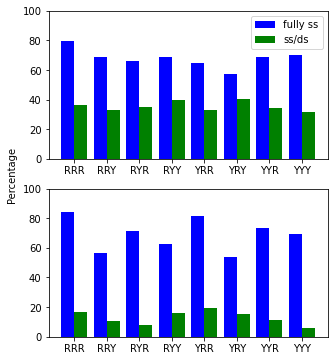

In [10]:
hist={"AAA":[], "AAC":[], "ACA":[], "ACC":[], "CAA":[], "CAC":[], "CCA":[], "CCC":[]}
tick = ["RRR", "RRY", "RYR", "RYY", "YRR", "YRY", "YYR", "YYY"]

for key in res_cluster_1A.keys():
    if (res_cluster_1A[key]["contact_ss"]+res_cluster_1A[key]["mixte_ss"]+res_cluster_1A[key]["nocontact_ss"]) != 0:
        hist[key].append(round((100*(res_cluster_1A[key]["contact_ss"]/(res_cluster_1A[key]["contact_ss"]+res_cluster_1A[key]["mixte_ss"]+res_cluster_1A[key]["nocontact_ss"]))),2))
    else:
        hist[key].append(0)
    if (res_cluster_1A[key]["contact_mixte"]+res_cluster_1A[key]["mixte_mixte"]+res_cluster_1A[key]["nocontact_mixte"]+res_cluster_1A[key]["contact_ds"]+res_cluster_1A[key]["mixte_ds"]+res_cluster_1A[key]["nocontact_ds"]) != 0:
        hist[key].append(round((100*((res_cluster_1A[key]["contact_mixte"]+res_cluster_1A[key]["contact_ds"])/(res_cluster_1A[key]["contact_mixte"]+res_cluster_1A[key]["mixte_mixte"]+res_cluster_1A[key]["nocontact_mixte"]+res_cluster_1A[key]["contact_ds"]+res_cluster_1A[key]["mixte_ds"]+res_cluster_1A[key]["nocontact_ds"]))),2))
    else:
        hist[key].append(0)
        
a = [row[0] for row in list(hist.values())]
b = [row[1] for row in list(hist.values())]

hist_3A={"AAA":[], "AAC":[], "ACA":[], "ACC":[], "CAA":[], "CAC":[], "CCA":[], "CCC":[]}

for key in res_cluster_3A.keys():
    if (res_cluster_3A[key]["contact_ss"]+res_cluster_3A[key]["mixte_ss"]+res_cluster_3A[key]["nocontact_ss"]) != 0:
        hist_3A[key].append(round((100*(res_cluster_3A[key]["contact_ss"]/(res_cluster_3A[key]["contact_ss"]+res_cluster_3A[key]["mixte_ss"]+res_cluster_3A[key]["nocontact_ss"]))),2))
    else:
        hist_3A[key].append(0)
    if (res_cluster_3A[key]["contact_mixte"]+res_cluster_3A[key]["mixte_mixte"]+res_cluster_3A[key]["nocontact_mixte"]+res_cluster_3A[key]["contact_ds"]+res_cluster_3A[key]["mixte_ds"]+res_cluster_3A[key]["nocontact_ds"]) != 0:
        hist_3A[key].append(round((100*((res_cluster_3A[key]["contact_mixte"]+res_cluster_3A[key]["contact_ds"])/(res_cluster_3A[key]["contact_mixte"]+res_cluster_3A[key]["mixte_mixte"]+res_cluster_3A[key]["nocontact_mixte"]+res_cluster_3A[key]["contact_ds"]+res_cluster_3A[key]["mixte_ds"]+res_cluster_3A[key]["nocontact_ds"]))),2))
    else:
        hist_3A[key].append(0)
        
a_3A = [row[0] for row in list(hist_3A.values())]
b_3A = [row[1] for row in list(hist_3A.values())]

fig4 = plt.figure(figsize=(5, 6))
gs = gridspec.GridSpec(2, 1)

x1= [i-0.2 for i in range(8)]
x2= [i+0.2 for i in range(8)]

ax1 = plt.subplot(gs[0, 0])
ax1.bar(x1, a, width=0.4, color='b', align='center', label="fully ss")
ax1.bar(x2, b, width=0.4, color='g', align='center', label="ss/ds")
ax1.xaxis.set_ticks(range(8))
ax1.xaxis.set_ticklabels(tick, color="black")
ax1.set_ylim(0,100)

ax2 = plt.subplot(gs[1, 0])
ax2.bar(x1, a_3A, width=0.4, color='b', align='center', label="fully ss")
ax2.bar(x2, b_3A, width=0.4, color='g', align='center', label="ss/ds")
ax2.xaxis.set_ticks(range(8))
ax2.xaxis.set_ticklabels(tick, color="black")
ax2.set_ylim(0,100)

fig4.text(0.01, 0.5, 'Percentage', va='center', rotation='vertical')
ax1.legend(loc="upper right")

plt.savefig("fig4.png", facecolor="w")
plt.show()


In [11]:
for motif in res_cluster_1A.keys():
    ss = res_cluster_1A[motif]["contact_ss"]+res_cluster_1A[motif]["nocontact_ss"]+res_cluster_1A[motif]["mixte_ss"]
    mixte = res_cluster_1A[motif]["contact_ds"]+res_cluster_1A[motif]["nocontact_ds"]+res_cluster_1A[motif]["mixte_ds"]+res_cluster_1A[motif]["contact_mixte"]+res_cluster_1A[motif]["nocontact_mixte"]+res_cluster_1A[motif]["mixte_mixte"]
    successes = np.array([res_cluster_1A[motif]["contact_ss"], res_cluster_1A[motif]["contact_ds"] + res_cluster_1A[motif]["contact_mixte"]])
    samples = np.array([ss, mixte])

    stat, p_value = proportions_ztest(count=successes, nobs=samples, alternative='two-sided')

    print(motif, stat, p_value)

AAA 10.670247518138023 1.4025227489836348e-26
AAC 7.261403818834081 3.830933632389385e-13
ACA 6.28192855772843 3.3439852031440037e-10
ACC 5.138137526127048 2.7747479061309284e-07
CAA 6.832636647144277 8.336792921303313e-12
CAC 3.1165040577754426 0.0018300916185707832
CCA 6.32029474410268 2.610648788352754e-10
CCC 8.3315291451425 7.98047848972002e-17


The next cell is showing the values in the Figure.5 of the paper.

In [12]:
print("           ss  mixte  ds  ")
print("nocontact ",res_cluster_1A['AAA']['nocontact_ss']," ", res_cluster_1A['AAA']['nocontact_mixte'], " ",res_cluster_1A['AAA']['nocontact_ds'])
print("mixte       ", res_cluster_1A['AAA']['mixte_ss'], "", res_cluster_1A['AAA']['mixte_mixte'], " ", res_cluster_1A['AAA']['mixte_ds'])
print("contact   ",res_cluster_1A['AAA']['contact_ss'], " ",res_cluster_1A['AAA']['contact_mixte'], "", res_cluster_1A['AAA']['contact_ds'])

           ss  mixte  ds  
nocontact  47   72   8
mixte        0  194   0
contact    184   146  9


## Size of interfaces in protein-bound RNA hairpin loops

In this part we are interested into hairpins, they are a particular secondary structure of the RNA. We will create a benchmark of hairpins here and then have a look at the number of nucleotides in contact with the protein.

In [13]:
%%bash

cd $PROTNAFF/data_paper
python $PROTNAFF/create_benchmark/filters/query_hairpin.py 3dna/ structures.json test_hairpin.list --ss 3 --ds 3 --contact 0

1A1T
1A34
1A4T
1A9N
1AQ3
1AQ4
1ASY
1ASZ
1AUD
1AV6
1B23
1B7F
1BIV
1BMV
1C0A
1C9S
1CVJ
1DDL
1DI2
1DRZ
1DUL
1DZ5
1E7K
1EC6
1EFW
1EKZ
1ETF
1ETG
1EUY
1EXD
1EXY
1F6U
1F7U
1F7V
1F8V
1FFY
1FJE
1FNX
1FXL
1G2E
1G59
1G70
1GAX
1GTF
1GTN
1GTR
1GTS
1H2C
1H2D
1H3E
1H4Q
1H4S
1HJI
1HQ1
1I5L
1I9F
1IL2
1IVS
1J1U
1JBR
1JBS
1JBT
1JID
1K1G
1K8W
1KNZ
1KQ2
1L1C
1L9A
1LNG
1M5K
1M5O
1M5P
1M5V
1M8V
1M8WA
1M8WB
1M8X
1M8Y
1MNB
1N1H
1N35
1N38
1N77
1N78
1NB7
1NYB
1O0B
1O0C
1OOA
1PGL
1Q2R
1QF6
1QFQ
1QRS
1QRT
1QRU
1QTQ
1QU2
1QU3
1R3E
1R9F
1RC7
1RGO
1RKJ
1RLG
1RMV
1RPUA
1RPUB
1S03
1SDS
1SER
1SI2
1SI3
1SJ3
1SJ4
1SJF
1T4L
1TFW
1TTT
1U0B
1U1Y
1U6P
1ULL
1URN
1UTD
1UVI
1UVJ
1UVL
1UVM
1UVN
1VBX
1VBY
1VBZ
1VC0
1VC6
1VFG
1WMQ
1WNE
1WPU
1WRQ
1WSU
1WWD
1WWE
1WWF
1WWG
1XOK
1Y39
1YTU
1YTY
1YVP
1YYK
1YYO
1YYW
1YZ9
1ZBH
1ZBN
1ZDH
1ZDI
1ZDJ
1ZDK
1ZE2
1ZH5
1ZHO
1ZJW
1ZL3
1ZSE
2A1R
2A8V
2A9X
2AB4
2AD9
2ADB
2ADC
2ANN
2ANR
2ASB
2ATW
2AZ0
2AZ2
2AZX
2B2D
2B3J
2B6G
2BBV
2BGG
2BH2
2BNY
2BQ5
2BS0
2BS1
2BTE
2BU1
2BX2
2C06
2C4Q
2C4Y
2C4Z
2C50
2

In [14]:
with open("{}/test_hairpin.list".format(folder)) as ff:
    lines = ff.readlines()

In [15]:
hairpins = []
for line in lines:
    try:
        tmp = line.rstrip().split()
        tmp[2] = int(tmp[2][2:-2])
        tmp[3] = int(tmp[3][1:-2])
        if len(tmp[-1]) == tmp[3] - tmp[2] + 1:
            hairpins.append(tmp)
    except:
        pass
print(len(hairpins))

1160


In [16]:
results_hairpins = {}
for hairpin in hairpins:
    try:
        if hairpin[0] not in results_hairpins.keys():
            results_hairpins[hairpin[0]] = {}
        if structures[hairpin[0]]["method"] == "solide nmr" or structures[hairpin[0]]["method"] == "solution nmr" or structures[hairpin[0]]["resolution"] < 3:
            jj = len(results_hairpins[hairpin[0]].keys())
            results_hairpins[hairpin[0]][jj] = {"contact_ss":0, "contact_ds":0, "nocontact":0}
            chain = "chain_" + hairpin[1]
            interface = set()
            for nucl in structures[hairpin[0]]["interface_protein"]["model_1"][chain].keys():
                tmp = nucl.split('_')[1]
                interface.add(structures[hairpin[0]]["mapping"][chain][tmp])
            for ii in range(hairpin[2], hairpin[3]+1):
                if str(ii) in interface:
                    if int(ii) - hairpin[2] < 3 or hairpin[3] - int(ii) < 3:
                        results_hairpins[hairpin[0]][jj]["contact_ds"] += 1
                    else:
                        results_hairpins[hairpin[0]][jj]["contact_ss"] += 1
                else:
                    results_hairpins[hairpin[0]][jj]["nocontact"] += 1
    except:
        pass

In [17]:
for key in results_hairpins.keys():
    pop_one = []
    for chain in results_hairpins[key].keys():
        if results_hairpins[key][chain]['contact_ss'] == 0:
            pop_one.append(chain)
    for ii in pop_one:
        results_hairpins[key].pop(ii)

In [18]:
length_contact = {}
for hh in results_hairpins.keys():
    for kk in results_hairpins[hh].keys():
        l = results_hairpins[hh][kk]['contact_ss'] + results_hairpins[hh][kk]["nocontact"] + results_hairpins[hh][kk]["contact_ds"] - 6
        if l in length_contact.keys():
            if results_hairpins[hh][kk]['contact_ss'] in length_contact[l].keys():
                length_contact[l][results_hairpins[hh][kk]['contact_ss']] += 1
            else:
                length_contact[l][results_hairpins[hh][kk]['contact_ss']] = 1
        else:
            length_contact[l]= {}
            length_contact[l][results_hairpins[hh][kk]['contact_ss']] = 1
print(length_contact)

{13: {12: 2, 11: 2, 13: 1}, 7: {7: 63, 1: 15, 5: 34, 6: 33, 4: 42, 2: 43, 3: 24}, 10: {9: 26, 8: 12, 10: 22, 1: 2, 3: 1}, 12: {11: 2}, 14: {10: 1}, 8: {3: 5, 2: 11, 1: 9, 8: 6, 7: 9, 6: 1, 5: 2, 4: 3}, 5: {5: 28, 4: 14, 1: 2, 2: 4, 3: 4}, 4: {3: 34, 4: 50, 1: 34, 2: 17}, 6: {5: 5, 1: 7, 2: 3, 6: 16, 4: 3}, 9: {3: 3, 1: 8, 7: 4, 9: 7, 8: 5, 6: 4, 4: 1, 2: 4}, 15: {9: 2, 15: 1}, 3: {3: 20, 1: 3}, 11: {10: 1, 11: 1, 2: 1}, 16: {11: 2, 6: 1}}


[13, 13, 13, 7, 7, 7, 7, 7, 7, 7, 10, 10, 10, 10, 10, 12, 14, 8, 8, 8, 8, 8, 8, 8, 8, 5, 5, 5, 5, 5, 4, 4, 4, 4, 6, 6, 6, 6, 6, 9, 9, 9, 9, 9, 9, 9, 9, 15, 15, 3, 3, 11, 11, 11, 16, 16] [12, 11, 13, 7, 1, 5, 6, 4, 2, 3, 9, 8, 10, 1, 3, 11, 10, 3, 2, 1, 8, 7, 6, 5, 4, 5, 4, 1, 2, 3, 3, 4, 1, 2, 5, 1, 2, 6, 4, 3, 1, 7, 9, 8, 6, 4, 2, 9, 15, 3, 1, 10, 11, 2, 11, 6]


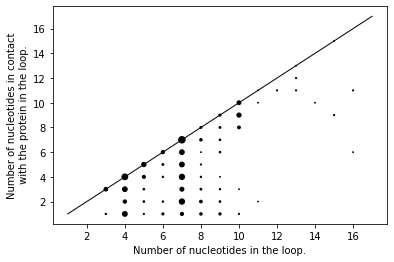

In [51]:
import numpy as np
x = []
y = []
points_size = []
for ii in length_contact.keys():
    for jj in range(len(list(length_contact[ii].keys()))):
        x.append(ii)
    for kk in length_contact[ii].keys():
        y.append(kk)
        points_size.append(length_contact[ii][kk])

z= [x/1.5 for x in points_size]
#z = [pow(1.25,x) for x in z]
print(x,y)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(x,y,c="black", s=z)
plt.plot([1,17],[1,17],'k-',lw=1)
plt.xlabel("Number of nucleotides in the loop.", color="black")
plt.ylabel("Number of nucleotides in contact\n with the protein in the loop.", color="black")

plt.savefig("fig6.png")

## Supplementary

Those are the supplementary data and figures of the paper.

The first filter selects all the single-stranded
nucleotides in contact with a protein (Suppl. XXX). To that end, two sets are constructed: 
one containing all the single-stranded nucleotides and one
containing all the nucleotides at the protein interface. Then the intersection
of these two sets is kept. As a result, 18,506 nucleotides are obtained from
1958 PDB chains (10 per PDB structure on average).

In [20]:
ss_set = set(["L", "T", "S", "J", "B", "I"])
struct = 0
nb_nucl = 0
for pdb_id in structures.keys():
    for chain in structures[pdb_id]["nachains"]:
        nuclfrag = set()
        chain_id = "chain_" + chain
        ss = structures[pdb_id]['ss'][chain_id]

        interf_prot = structures[pdb_id]["interface_protein"]["model_1"][chain_id]
        # print(interf_prot)
        for element in interf_prot:
            element = element.split("_")[1]

        # List of interface nucleotide resid
        nucl_interf = list(interf_prot.keys())
        nucl_interf = [element.split("_")[1] for element in nucl_interf]
        # List of single-stranded nucleotides resid
        nucl_ss = [n.split("_")[1] for n in ss if ss[n][0] in ss_set]
        # List of single-stranded interface nucleotide resid
        nucl_interf_ss = [int(n) for n in nucl_interf if n in nucl_ss]
        nucl_interf_ss.sort()
        if len(nucl_interf_ss) > 0:
            struct += 1
            nb_nucl += len(nucl_interf_ss)
        #print(pdb_id, chain_id, nucl_interf_ss)
print("Number of RNA chains: {} \nNumber of nucleotides: {}".format(struct, nb_nucl))

Number of RNA chains: 1958 
Number of nucleotides: 18506


The second filter can be found in `./create_benchmark/filters/query_hairpin.py`, it is more complicated than the previous one. If you need explanation you can send us a mail.

The next 3 cells are here to calculate the percentage of trinucleotides in contact with proteins according to the sequence.

In [21]:
letter = ["A", "U", "G", "C"]
resultats_all = {}
for ii in letter:
    for jj in letter:
        for kk in letter:
            resultats_all[ii+jj+kk] = {}

for key in fragments.keys():
    for key2 in fragments[key].keys():
        model = "model_" + str(fragments[key][key2]["model"])
        chain = "chain_" + str(fragments[key][key2]["chain"])
        seq = fragments[key][key2]['seq']
        contact = False
        interface = set()
        nucl2=[]
        mapping_rev={}
        for nn in structures[fragments[key][key2]['structure']]["mapping"][chain].keys():
            mapping_rev[structures[fragments[key][key2]['structure']]["mapping"][chain][nn]] = nn
        for nucl in structures[fragments[key][key2]['structure']]["interface_protein"]["model_1"][chain].keys():
            tmp = nucl.split('_')[1]
            interface.add(structures[fragments[key][key2]['structure']]["mapping"][chain][tmp])
        ss=True
        ds=0
        for nucl in fragments[key][key2]['resid']:
            if nucl in interface:
                contact = True
            nucl2.append(mapping_rev[nucl])
        for nucl in nucl2:
            if structures[fragments[key][key2]['structure']]["ss"][chain]["res_"+nucl][0]=="D":
                ss=False
                ds+=1
        if fragments[key][key2]['clust1.0'] not in resultats_all[seq].keys():
            resultats_all[seq][fragments[key][key2]['clust1.0']] = {"contact_ss":0, "contact_ds":0, "contact_mixte":0, "nocontact_ss":0, "nocontact_ds":0, "nocontact_mixte":0}
        if contact:
            if ss:
                resultats_all[seq][fragments[key][key2]['clust1.0']]["contact_ss"] += 1
            elif ds == 3:
                resultats_all[seq][fragments[key][key2]['clust1.0']]["contact_ds"] += 1
            else:
                resultats_all[seq][fragments[key][key2]['clust1.0']]["contact_mixte"] += 1
        else:
            if ss:
                resultats_all[seq][fragments[key][key2]['clust1.0']]["nocontact_ss"] += 1
            elif ds == 3:
                resultats_all[seq][fragments[key][key2]['clust1.0']]["nocontact_ds"] += 1
            else:
                resultats_all[seq][fragments[key][key2]['clust1.0']]["nocontact_mixte"] += 1
        

In [22]:
letter = ["A", "U", "G", "C"]
resultats_all_bis = {}
for ii in letter:
    for jj in letter:
        for kk in letter:
            resultats_all_bis[ii+jj+kk] = {}
            
for key in resultats_all.keys():
    con_ss = 0
    sum_con_ss = 0
    con_ds = 0
    sum_con_ds = 0
    con_mixte = 0
    sum_con_mixte = 0
    nocon_ss = 0
    sum_nocon_ss = 0
    nocon_ds = 0
    sum_nocon_ds = 0
    nocon_mixte = 0
    sum_nocon_mixte = 0
    mixte_ss = 0
    sum_mixte_ss = 0
    mixte_ds = 0
    sum_mixte_ds = 0
    mixte_mixte = 0
    sum_mixte_mixte=0
    j = 0
    print(key)
    for clust in resultats_all[key].keys():
        j += 1
        if resultats_all[key][clust]["contact_ss"] + resultats_all[key][clust]["contact_ds"] + resultats_all[key][clust]["contact_mixte"] + resultats_all[key][clust]["nocontact_ss"] + resultats_all[key][clust]["nocontact_ds"] + resultats_all[key][clust]["nocontact_mixte"] > 2:
            if resultats_all[key][clust]["nocontact_mixte"] == 0 and resultats_all[key][clust]["nocontact_ds"] == 0 and resultats_all[key][clust]["nocontact_ss"] == 0:
                #print(clust, results[key][clust])
                if resultats_all[key][clust]["contact_mixte"] > 0:
                    con_mixte += 1
                    sum_con_mixte += resultats_all[key][clust]["contact_ss"] + resultats_all[key][clust]["contact_ds"] + resultats_all[key][clust]["contact_mixte"]
                else:
                    if resultats_all[key][clust]["contact_ds"] == 0:
                        con_ss += 1
                        sum_con_ss += resultats_all[key][clust]["contact_ss"]
                    else:
                        con_ds += 1
                        sum_con_ds += resultats_all[key][clust]["contact_ds"]
            elif resultats_all[key][clust]["contact_ss"] == 0 and resultats_all[key][clust]["contact_ds"] == 0 and resultats_all[key][clust]["contact_mixte"] == 0:
                if resultats_all[key][clust]["nocontact_mixte"] > 0:
                    nocon_mixte += 1
                    sum_nocon_mixte += resultats_all[key][clust]["nocontact_ss"] + resultats_all[key][clust]["nocontact_ds"] + resultats_all[key][clust]["nocontact_mixte"]
                else:
                    if resultats_all[key][clust]["nocontact_ss"] == 0:
                        nocon_ds += 1
                        sum_nocon_ds += resultats_all[key][clust]["nocontact_ds"]
                    else:
                        nocon_ss += 1
                        sum_nocon_ss += resultats_all[key][clust]["nocontact_ss"]

            else:
                if resultats_all[key][clust]["nocontact_mixte"] > 0 or resultats_all[key][clust]["contact_mixte"] > 0 or (resultats_all[key][clust]["nocontact_ss"] != 0 and resultats_all[key][clust]["nocontact_ds"] !=0) or (resultats_all[key][clust]["contact_ss"] != 0 or resultats_all[key][clust]["contact_ds"] !=0):
                    mixte_mixte += 1
                    sum_mixte_mixte += resultats_all[key][clust]["nocontact_ss"] + resultats_all[key][clust]["nocontact_ds"] + resultats_all[key][clust]["nocontact_mixte"] + resultats_all[key][clust]["contact_ss"] + resultats_all[key][clust]["contact_ds"] + resultats_all[key][clust]["contact_mixte"]
                else:
                    if resultats_all[key][clust]["contact_ss"] == 0 and resultats_all[key][clust]["nocontact_ss"] == 0:
                        mixte_ds += 1
                        sum_mixte_ds += resultats_all[key][clust]["nocontact_ds"] + resultats_all[key][clust]["contact_ds"]
                    else:
                        mixte_ss += 1
                        sum_mixte_ss += resultats_all[key][clust]["contact_ss"] + resultats_all[key][clust]["nocontact_ss"]             

    resultats_all_bis[key] = {"contact_ss":con_ss, "contact_ds":con_ds, "contact_mixte":con_mixte, "nocontact_ss":nocon_ss, "nocontact_ds":nocon_ds, "nocontact_mixte":nocon_mixte, "mixte_ss":mixte_ss, "mixte_ds":mixte_ds, "mixte_mixte":mixte_mixte, \
                   "sum_contact_ss":sum_con_ss, "sum_contact_ds":sum_con_ds, "sum_contact_mixte":sum_con_mixte, \
                   "sum_nocontact_ss":sum_nocon_ss, "sum_nocontact_ds":sum_nocon_ds, "sum_nocontact_mixte":sum_nocon_mixte,\
                   "sum_mixte_ss":sum_mixte_ss, "sum_mixte_ds":sum_mixte_ds, "sum_mixte_mixte":sum_mixte_mixte}
    

AAA
AAU
AAG
AAC
AUA
AUU
AUG
AUC
AGA
AGU
AGG
AGC
ACA
ACU
ACG
ACC
UAA
UAU
UAG
UAC
UUA
UUU
UUG
UUC
UGA
UGU
UGG
UGC
UCA
UCU
UCG
UCC
GAA
GAU
GAG
GAC
GUA
GUU
GUG
GUC
GGA
GGU
GGG
GGC
GCA
GCU
GCG
GCC
CAA
CAU
CAG
CAC
CUA
CUU
CUG
CUC
CGA
CGU
CGG
CGC
CCA
CCU
CCG
CCC


In [23]:
for motif in resultats_all_bis.keys():
    print(motif, (resultats_all_bis[motif]["sum_contact_ss"]+resultats_all_bis[motif]["sum_contact_ds"]+resultats_all_bis[motif]["sum_contact_mixte"])/(resultats_all_bis[motif]["sum_contact_ss"]+resultats_all_bis[motif]["sum_contact_ds"]+resultats_all_bis[motif]["sum_contact_mixte"]+resultats_all_bis[motif]["sum_mixte_ss"]+resultats_all_bis[motif]["sum_mixte_ds"]+resultats_all_bis[motif]["sum_mixte_mixte"]+resultats_all_bis[motif]["sum_nocontact_ss"]+resultats_all_bis[motif]["sum_nocontact_ds"]+resultats_all_bis[motif]["sum_nocontact_mixte"]))

AAA 0.3406060606060606
AAU 0.21160042964554243
AAG 0.19573215599705665
AAC 0.1813186813186813
AUA 0.24259055982436883
AUU 0.20704467353951891
AUG 0.11979166666666667
AUC 0.10371650821089023
AGA 0.15457184325108853
AGU 0.2643137254901961
AGG 0.12190187152250885
AGC 0.11632390745501285
ACA 0.26094890510948904
ACU 0.0983009708737864
ACG 0.08817829457364341
ACC 0.1383344803854095
UAA 0.21032745591939547
UAU 0.22386223862238622
UAG 0.16890080428954424
UAC 0.15748898678414097
UUA 0.22142857142857142
UUU 0.3884107860011474
UUG 0.13189771197846567
UUC 0.17041334300217548
UGA 0.25
UGU 0.21037463976945245
UGG 0.0667107001321004
UGC 0.1291314373558801
UCA 0.15670910871694418
UCU 0.1111864406779661
UCG 0.12084592145015106
UCC 0.06846846846846846
GAA 0.19651240778001342
GAU 0.17396991497710923
GAG 0.1715587044534413
GAC 0.09271935283136279
GUA 0.17817561807331628
GUU 0.10727272727272727
GUG 0.1724137931034483
GUC 0.0686482661004954
GGA 0.12595573440643862
GGU 0.09379128137384413
GGG 0.0645292207792

The next two cells are creating the LaTeX tables found in supplementary in the paper.
They are presenting the number of clusters depending of their characteristics (ss/ds, contact/no contact). The numbers in brackets are the number of conformations.

In [24]:
for key in res_cluster_1A.keys():
    sum_tt = res_cluster_1A[key]['sum_contact_ss']+res_cluster_1A[key]['sum_contact_ds']+res_cluster_1A[key]['sum_contact_mixte']+res_cluster_1A[key]['sum_nocontact_ss']+res_cluster_1A[key]['sum_nocontact_ds']+res_cluster_1A[key]['sum_nocontact_mixte']+res_cluster_1A[key]['sum_mixte_ss']+res_cluster_1A[key]['sum_mixte_ds']+res_cluster_1A[key]['sum_mixte_mixte']
    texte = []
    texte.append("\hline")
    texte.append("{} & ss & mixed & ds   & total \\\\ \hline".format(key))
    texte.append("contact   & {}({}) & {}({})   & {}({}) & {}({})  \\\\ \hline".format(res_cluster_1A[key]['contact_ss'], res_cluster_1A[key]['sum_contact_ss'], res_cluster_1A[key]['contact_mixte'], res_cluster_1A[key]['sum_contact_mixte'], res_cluster_1A[key]['contact_ds'], res_cluster_1A[key]['sum_contact_ds'], str(res_cluster_1A[key]['contact_ss']+res_cluster_1A[key]['contact_mixte']+res_cluster_1A[key]['contact_ds']), str(res_cluster_1A[key]['sum_contact_ss']+res_cluster_1A[key]['sum_contact_mixte']+res_cluster_1A[key]['sum_contact_ds'])))
    texte.append("mixed   & {}({}) & {}({})   & {}({}) & {}({})  \\\\ \hline".format(res_cluster_1A[key]['mixte_ss'], res_cluster_1A[key]['sum_mixte_ss'], res_cluster_1A[key]['mixte_mixte'], res_cluster_1A[key]['sum_mixte_mixte'],  res_cluster_1A[key]['mixte_ds'], res_cluster_1A[key]['sum_mixte_ds'], str(res_cluster_1A[key]['mixte_ss']+res_cluster_1A[key]['mixte_mixte']+res_cluster_1A[key]['mixte_ds']), str(res_cluster_1A[key]['sum_mixte_ss']+res_cluster_1A[key]['sum_mixte_mixte']+res_cluster_1A[key]['sum_mixte_ds'])))
    texte.append("nocontact &  {}({}) & {}({})   & {}({}) & {}({})  \\\\ \hline".format(res_cluster_1A[key]['nocontact_ss'], res_cluster_1A[key]['sum_nocontact_ss'], res_cluster_1A[key]['nocontact_mixte'], res_cluster_1A[key]['sum_nocontact_mixte'], res_cluster_1A[key]['nocontact_ds'], res_cluster_1A[key]['sum_nocontact_ds'], str(res_cluster_1A[key]['nocontact_ss']+res_cluster_1A[key]['nocontact_mixte']+res_cluster_1A[key]['nocontact_ds']), str(res_cluster_1A[key]['sum_nocontact_ss']+res_cluster_1A[key]['sum_nocontact_mixte']+res_cluster_1A[key]['sum_nocontact_ds'])))
    texte.append("total   & {}({}) & {}({})   & {}({}) & {}({})  \\\\ \hline".format(res_cluster_1A[key]['contact_ss']+res_cluster_1A[key]['mixte_ss']+res_cluster_1A[key]['nocontact_ss'], str(res_cluster_1A[key]['sum_contact_ss']+res_cluster_1A[key]['sum_mixte_ss']+res_cluster_1A[key]['sum_nocontact_ss']), res_cluster_1A[key]['contact_mixte']+res_cluster_1A[key]['mixte_mixte']+res_cluster_1A[key]['nocontact_mixte'], res_cluster_1A[key]['sum_contact_mixte']+res_cluster_1A[key]['sum_mixte_mixte']+res_cluster_1A[key]['sum_nocontact_mixte'], res_cluster_1A[key]['contact_ds']+res_cluster_1A[key]['mixte_ds']+res_cluster_1A[key]['nocontact_ds'], res_cluster_1A[key]['sum_contact_ds']+res_cluster_1A[key]['sum_mixte_ds']+res_cluster_1A[key]['sum_nocontact_ds'], str(res_cluster_1A[key]['contact_ss']+res_cluster_1A[key]['contact_mixte']+res_cluster_1A[key]['contact_ds']+res_cluster_1A[key]['mixte_ss']+res_cluster_1A[key]['mixte_mixte']+res_cluster_1A[key]['mixte_ds']+res_cluster_1A[key]['nocontact_ss']+res_cluster_1A[key]['nocontact_mixte']+res_cluster_1A[key]['nocontact_ds']), sum_tt))
    for ii in texte:
        print(ii)

\hline
AAA & ss & mixed & ds   & total \\ \hline
contact   & 184(1255) & 146(823)   & 9(47) & 339(2125)  \\ \hline
mixed   & 0(0) & 194(12286)   & 0(0) & 194(12286)  \\ \hline
nocontact &  47(315) & 72(427)   & 8(62) & 127(804)  \\ \hline
total   & 231(1570) & 412(13536)   & 17(109) & 660(15215)  \\ \hline
\hline
AAC & ss & mixed & ds   & total \\ \hline
contact   & 101(712) & 107(562)   & 8(45) & 216(1319)  \\ \hline
mixed   & 0(0) & 149(10432)   & 0(0) & 149(10432)  \\ \hline
nocontact &  46(242) & 73(466)   & 9(43) & 128(751)  \\ \hline
total   & 147(954) & 329(11460)   & 17(88) & 493(12502)  \\ \hline
\hline
ACA & ss & mixed & ds   & total \\ \hline
contact   & 108(782) & 91(418)   & 6(26) & 205(1226)  \\ \hline
mixed   & 0(0) & 115(8264)   & 0(0) & 115(8264)  \\ \hline
nocontact &  55(400) & 50(415)   & 13(82) & 118(897)  \\ \hline
total   & 163(1182) & 256(9097)   & 19(108) & 438(10387)  \\ \hline
\hline
ACC & ss & mixed & ds   & total \\ \hline
contact   & 78(444) & 83(426)   & 

In [25]:
for key in res_cluster_3A.keys():
    sum_tt = res_cluster_3A[key]['sum_contact_ss']+res_cluster_3A[key]['sum_contact_ds']+res_cluster_3A[key]['sum_contact_mixte']+res_cluster_3A[key]['sum_nocontact_ss']+res_cluster_3A[key]['sum_nocontact_ds']+res_cluster_3A[key]['sum_nocontact_mixte']+res_cluster_3A[key]['sum_mixte_ss']+res_cluster_3A[key]['sum_mixte_ds']+res_cluster_3A[key]['sum_mixte_mixte']
    texte = []
    texte.append("\hline")
    texte.append("{} & ss & mixed & ds   & total \\\\ \hline".format(key))
    texte.append("contact   & {}({}) & {}({})   & {}({}) & {}({})  \\\\ \hline".format(res_cluster_3A[key]['contact_ss'], res_cluster_3A[key]['sum_contact_ss'], res_cluster_3A[key]['contact_mixte'], res_cluster_3A[key]['sum_contact_mixte'], res_cluster_3A[key]['contact_ds'], res_cluster_3A[key]['sum_contact_ds'], str(res_cluster_3A[key]['contact_ss']+res_cluster_3A[key]['contact_mixte']+res_cluster_3A[key]['contact_ds']), str(res_cluster_3A[key]['sum_contact_ss']+res_cluster_3A[key]['sum_contact_mixte']+res_cluster_3A[key]['sum_contact_ds'])))
    texte.append("mixed   & {}({}) & {}({})   & {}({}) & {}({})  \\\\ \hline".format(res_cluster_3A[key]['mixte_ss'], res_cluster_3A[key]['sum_mixte_ss'], res_cluster_3A[key]['mixte_mixte'], res_cluster_3A[key]['sum_mixte_mixte'],  res_cluster_3A[key]['mixte_ds'], res_cluster_3A[key]['sum_mixte_ds'], str(res_cluster_3A[key]['mixte_ss']+res_cluster_3A[key]['mixte_mixte']+res_cluster_3A[key]['mixte_ds']), str(res_cluster_3A[key]['sum_mixte_ss']+res_cluster_3A[key]['sum_mixte_mixte']+res_cluster_3A[key]['sum_mixte_ds'])))
    texte.append("nocontact &  {}({}) & {}({})   & {}({}) & {}({})  \\\\ \hline".format(res_cluster_3A[key]['nocontact_ss'], res_cluster_3A[key]['sum_nocontact_ss'], res_cluster_3A[key]['nocontact_mixte'], res_cluster_3A[key]['sum_nocontact_mixte'], res_cluster_3A[key]['nocontact_ds'], res_cluster_3A[key]['sum_nocontact_ds'], str(res_cluster_3A[key]['nocontact_ss']+res_cluster_3A[key]['nocontact_mixte']+res_cluster_3A[key]['nocontact_ds']), str(res_cluster_3A[key]['sum_nocontact_ss']+res_cluster_3A[key]['sum_nocontact_mixte']+res_cluster_3A[key]['sum_nocontact_ds'])))
    texte.append("total   & {}({}) & {}({})   & {}({}) & {}({})  \\\\ \hline".format(res_cluster_3A[key]['contact_ss']+res_cluster_3A[key]['mixte_ss']+res_cluster_3A[key]['nocontact_ss'], str(res_cluster_3A[key]['sum_contact_ss']+res_cluster_3A[key]['sum_mixte_ss']+res_cluster_3A[key]['sum_nocontact_ss']), res_cluster_3A[key]['contact_mixte']+res_cluster_3A[key]['mixte_mixte']+res_cluster_3A[key]['nocontact_mixte'], res_cluster_3A[key]['sum_contact_mixte']+res_cluster_3A[key]['sum_mixte_mixte']+res_cluster_3A[key]['sum_nocontact_mixte'], res_cluster_3A[key]['contact_ds']+res_cluster_3A[key]['mixte_ds']+res_cluster_3A[key]['nocontact_ds'], res_cluster_3A[key]['sum_contact_ds']+res_cluster_3A[key]['sum_mixte_ds']+res_cluster_3A[key]['sum_nocontact_ds'], str(res_cluster_3A[key]['contact_ss']+res_cluster_3A[key]['contact_mixte']+res_cluster_3A[key]['contact_ds']+res_cluster_3A[key]['mixte_ss']+res_cluster_3A[key]['mixte_mixte']+res_cluster_3A[key]['mixte_ds']+res_cluster_3A[key]['nocontact_ss']+res_cluster_3A[key]['nocontact_mixte']+res_cluster_3A[key]['nocontact_ds']), sum_tt))
    for ii in texte:
        print(ii)

\hline
AAA & ss & mixed & ds   & total \\ \hline
contact   & 32(197) & 26(189)   & 0(0) & 58(386)  \\ \hline
mixed   & 0(0) & 119(16860)   & 0(0) & 119(16860)  \\ \hline
nocontact &  6(24) & 10(81)   & 0(0) & 16(105)  \\ \hline
total   & 38(221) & 155(17130)   & 0(0) & 193(17351)  \\ \hline
\hline
AAC & ss & mixed & ds   & total \\ \hline
contact   & 13(108) & 13(72)   & 0(0) & 26(180)  \\ \hline
mixed   & 0(0) & 99(13933)   & 0(0) & 99(13933)  \\ \hline
nocontact &  10(65) & 10(39)   & 0(0) & 20(104)  \\ \hline
total   & 23(173) & 122(14044)   & 0(0) & 145(14217)  \\ \hline
\hline
ACA & ss & mixed & ds   & total \\ \hline
contact   & 20(139) & 9(75)   & 0(0) & 29(214)  \\ \hline
mixed   & 0(0) & 96(11550)   & 0(0) & 96(11550)  \\ \hline
nocontact &  8(61) & 9(60)   & 0(0) & 17(121)  \\ \hline
total   & 28(200) & 114(11685)   & 0(0) & 142(11885)  \\ \hline
\hline
ACC & ss & mixed & ds   & total \\ \hline
contact   & 15(77) & 18(164)   & 0(0) & 33(241)  \\ \hline
mixed   & 0(0) & 89(120